# Model 1: one airline, one airport

In [1]:
# initialization
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")
from sklearn.linear_model import Ridge

In [2]:
# load files
airlines = pd.read_csv('data_alex/airlines.csv')
airports = pd.read_csv('data_alex/airports.csv')
train = pd.read_csv('data_alex/flights_train.csv')
test = pd.read_csv('data_alex/flights_test.csv')
submit = pd.read_csv('data_alex/submit_sample.csv')

In [3]:
# add DATE column
train['DATE'] = pd.to_datetime(train[['YEAR','MONTH', 'DAY']])
test['DATE'] = pd.to_datetime(test[['YEAR','MONTH', 'DAY']])

In [4]:
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [5]:
# add departure delay
train['DEPARTURE_DELAY'] = train['DEPARTURE_TIME'] - train['SCHEDULED_DEPARTURE']
test['DEPARTURE_DELAY'] = test['DEPARTURE_TIME'] - test['SCHEDULED_DEPARTURE']

In [6]:
# modify train dataframe variables
train['SCHEDULED_DEPARTURE'] = create_flight_time(train, 'SCHEDULED_DEPARTURE')
train['DEPARTURE_TIME'] = train['DEPARTURE_TIME'].apply(format_heure)
train['SCHEDULED_ARRIVAL'] = train['SCHEDULED_ARRIVAL'].apply(format_heure)

In [7]:
# modify test dataframe variables
test['SCHEDULED_DEPARTURE'] = create_flight_time(test, 'SCHEDULED_DEPARTURE')
test['DEPARTURE_TIME'] = test['DEPARTURE_TIME'].apply(format_heure)
test['SCHEDULED_ARRIVAL'] = test['SCHEDULED_ARRIVAL'].apply(format_heure)

In [8]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

In [9]:
# a class to produce graphs
class Figure_style():
    #_________________________________________________________________
    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))
        #________________________________
        # convert self.axs to 2D array
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
    #_____________________________
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    #_______________
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
    #________________________________________
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
    #_________________________________________________________________________________
    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()
    #________________________________________________________________________
    def cust_plot_date(self, x, y, color='lightblue', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)
    #________________________________________________________________________
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)    
    #___________________________________________
    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)
    #___________________________________________
    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
    #____________________________________
    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    #____________________________________
    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])      

Model the delays by considering separately the different airlines and by splitting the data according to the different home airports. This first model can be seen as a "toy-model" that enables to identify problems that may arise at the production stage. When treating the whole dataset, the number of fits will be large. Hence we have to be sure that the automation of the whole process is robust enough to insure the quality of the fits.

Pitfalls 1 airline, 1 airport:
- unsufficient data: the least visited airports only have a few flights per month (unfit for linear regression)
- extreme delays: large delays create bias and significantly change the model (with small sets)

**Polynomial degree: splitting the dataset**
- Instead of simple linear regression, we can improve the model doing a fit with a polynomial of order  N.
- Doing so, it is necessary to define the degree  N  which is optimal to represent the data. 
- When increasing the polynomial order, it is important to prevent over-fitting and we do this by splitting the dataset in test and training sets.

A problem that may arise with this procedure is that the model ends by indirectly learning the contents of the test set and is thus biased. To avoid this, the data can be re-separated into 3 sets: train, test and validation. An alternative to this technique, which is often more robust, is the so-called cross-validation method. This method consists of performing a first separation of the data in training and test sets. As always, learning is done on the training set, but to avoid over-learning, it is split into several pieces that are used alternately for training and testing.

Note that if the data set is small, the separation in test & training sets can introduce a bias in the estimation of the parameters. In practice, the cross-validation method avoids such bias. In fact, in the current model, we will encounter this type of problem and in what follows, I will highlight this. For example, we can consider an extreme case where, after separation, the training set would contain only hours  < 20h and the test set would have hours >  20h. The model would then be unable to reproduce precisely this data, of which it would not have seen equivalent during the training. The cross-validation method avoids this bias because all the data are used successively to drive the model.

In [10]:
class fit_polynome:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)

    def split(self, method):        
        self.method = method        
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

        if method == 'all':
            self.X_train = self.X
            self.Y_train = self.Y
            self.X_test  = self.X
            self.Y_test  = self.Y                        
        elif method == 'split':            
            self.X_train, self.X_test, self.Y_train, self.Y_test = \
                train_test_split(self.X, self.Y, test_size=0.3)
    
    def train(self, pol_order):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X_train)
        self.regr.fit(self.X_, self.Y_train)
    
    def predict(self, X):
        self.X_ = self.poly.fit_transform(X)
        self.result = self.regr.predict(self.X_)
    
    def calc_score(self):        
        X_ = self.poly.fit_transform(self.X_test)
        result = self.regr.predict(X_)
        self.score = metrics.mean_squared_error(result, self.Y_test)

The fit_polynome class allows you to perform all operations related to a fit and to save the results. When calling the split() method, the variable 'method' defines how the initial data is separated:

- method = 'all' : all input data is used to train and then test the model
- method = 'split' : we use the train_test_split() method of sklearn to define test & training sets

Then, the other methods of the class have the following functions:

- train (n) : drives the data on the training set and makes a polynomial of order n
- predict (X) : calculates the Y points associated with the X input and for the previously driven model
- calc_score () : calculates the model score in relation to the test set data

First of all, I consider the American Airlines flights and make a census of the number of flights that left each airport:

In [11]:
carrier = 'AA'
check_airports = train[(train['AIRLINE'] == carrier)]['DEPARTURE_DELAY'].groupby(
                         train['ORIGIN_AIRPORT']).apply(get_stats).unstack()
check_airports.sort_values('count', ascending = False, inplace = True)
check_airports[-5:]

,min,max,count,mean
ORIGIN_AIRPORT,,,,
GUC,-62.0,773.0,94.0,9.702128
ANC,-6.0,114.0,27.0,25.000000
XNA,-53.0,2.0,16.0,-14.937500
MTJ,-12.0,91.0,13.0,18.769231
LIT,-45.0,114.0,9.0,8.111111


Define a function that calculates the mean flights delay per airline and per airport:

In [12]:
def get_flight_delays(train, carrier, id_airport, extrem_values = False):
    df2 = train[(train['AIRLINE'] == carrier) & (train['ORIGIN_AIRPORT'] == id_airport)]
    #_______________________________________
    # remove extreme values before fitting
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    #__________________________________
    # Conversion: date + heure -> heure
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    #___________________________________________________________________
    # regroupement des vols par heure de départ et calcul de la moyenne
    test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)
    #___________________________________
    # conversion de l'heure en secondes
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    test2.reset_index(inplace=True)
    test2['heure_depart_min'] = test2['heure_depart'].apply(fct)
    return test2

One of the advantages of the cross-validation method is that it avoids the bias that has just been put forward when choosing the polynomial degree. In order to use this method, I define a new class that I will use later to perform the fits:

In [13]:
class fit_polynome_cv:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

    def train(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.result = cross_val_predict(self.regr, self.X_, self.Y, cv = nb_folds)
    
    def calc_score(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.score = np.mean(cross_val_score(self.regr, self.X_, self.Y,
                                             cv = nb_folds, scoring = 'neg_mean_squared_error'))

In [14]:
#id_airport = 1129804 
nb_folds = 10
print('Max possible number of folds: {} \n'.format(test2.shape[0]-1))
fit2 = fit_polynome_cv(test2)
for i in range(1, 8):
    fit2.calc_score(i, nb_folds)
    print('n={} -> MSE = {}'.format(i, round(abs(fit2.score),3)))

NameError: name 'test2' is not defined

We can see that using this method gives us that the best model (ie the best generalized model) is obtained with a polynomial of order 3. At this stage of the procedure, the choice of the polynomial order a has been validated and we can now use all the data in order to perform the fit:

In [19]:
fit = fit_polynome(test2)
fit.split('all')
fit.train(pol_order = 3)
fit.predict(fit.X)

In [20]:
fit2.train(pol_order = 3, nb_folds = nb_folds)

Thus, in the following figure, the juxtaposition of the K = 50 polynomial fits corresponding to the cross validation calculation leads to the red curve. The polynomial fit corresponding to the final model corresponds to the blue curve.

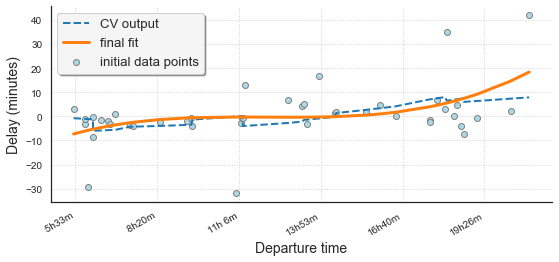

In [23]:
fig1 = Figure_style(8, 4, 1, 1) ; fig1.pos_update(0, 0)
fig1.cust_scatter(fit2.X, fit2.Y, markeredge = True, label = 'initial data points')
fig1.cust_plot(fit.X,fit2.result,color=u'#1f77b4',linestyle='--',linewidth=2,label='CV output')
fig1.cust_plot(fit.X,fit.result,color=u'#ff7f0e',linewidth = 3,label='final fit')
fig1.style(); fig1.draw_legend('upper left')
fig1.set_ylabel('Delay (minutes)') ; fig1.set_xlabel('Departure time')
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);

In [24]:
score = metrics.mean_squared_error(fit.result, fit2.Y)
score

106.02582415979914

At this stage, the model was driven is tested on the training set. We now look at the comparison of predictions and observations for the test set.

In [25]:
test_data = get_flight_delays(test, carrier, id_airport, True)
test_data = test_data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
X_test = np.array(test_data['heure_depart_min'])
Y_test = np.array(test_data['mean'])
X_test = X_test.reshape(len(X_test),1)
Y_test = Y_test.reshape(len(Y_test),1)
fit.predict(X_test)

In [26]:
score = metrics.mean_squared_error(fit.result, Y_test)
score

102.38779638300275

The difference in minutes between the predicted delay and the actual delay.

In [28]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 10.12 min'